# Text Analytics Pipeline for Text Classification

This section demonstrates how to build a text analytics pipeline that includes text processing, feature extraction, classification, and evaluation.


To Download GloVe pretrained word vectors :

In [1]:
# Pipeline to load or download the dataset
# """
# TODO
# """

Modules:

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.corpus import stopwords
import emoji
import spacy
import contractions

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import TruncatedSVD
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. 1. Custom Text Preprocessor

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Punctuation Removal:** Removes punctuation using regex.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [3]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, do_stemming=True, do_lemmatization=False, remove_stopwords=True, 
                 do_emoji_conversion=True, use_spacy_tokenizer=True):
        """
        Parameters:
        - do_stemming: Apply stemming (reduces words to their root form)
        - do_lemmatization: Apply lemmatization (converts words to their canonical form)
          Note: When using the default (NLTK) tokenizer, if both do_lemmatization and do_stemming are enabled,
          lemmatization takes precedence.
        - remove_stopwords: Remove common stopwords
        - do_emoji_conversion: Convert emojis to text descriptions
        - use_spacy_tokenizer: Use a custom spaCy-based tokenizer (which already uses lemmatization)
        """
        self.do_stemming = do_stemming
        self.do_lemmatization = do_lemmatization
        self.remove_stopwords = remove_stopwords
        self.do_emoji_conversion = do_emoji_conversion
        self.use_spacy_tokenizer = use_spacy_tokenizer
        self.stemmer = PorterStemmer()
        if self.do_lemmatization:
            self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Load the spaCy model if using the spaCy tokenizer
        if self.use_spacy_tokenizer:
            self.nlp = spacy.load("en_core_web_sm")
    
    def remove_links(self, text):
        """Remove URLs from text."""
        return re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    
    def remove_user_mentions(self, text):
        """Remove user mentions from text."""
        return re.sub(r'u/\S+', '', text)
    
    def expand_contractions(self, text):
        """Expand contractions in the text."""
        return contractions.fix(text)
    
    def remove_non_ascii(self, text):
        """Remove non-ASCII characters from the text."""
        return text.encode("ascii", "ignore").decode()
    
    def remove_punctuations(self, text):
        """
        Remove or adjust punctuation in text.
        Replaces hyphens with space and ensures separation around punctuation.
        """
        text = re.sub(r'[-]', ' ', text)
        text = re.sub(r'(\S)[' + re.escape(string.punctuation) + r'](\S)', r'\1 \2', text)
        return text
    
    def remove_numbers(self, text):
        """Remove numbers from text."""
        return re.sub(r'[0-9]+', '', text)
    
    def emoji_to_text(self, text):
        """Convert emojis to text descriptions."""
        return emoji.demojize(text)
    
    def normalize(self, text):
        """Lowercase the text."""
        return text.lower()
    
    def tokenize(self, text):
        """
        Tokenize text using either a spaCy-based custom tokenizer or the default NLTK tokenizer.
        """
        if self.use_spacy_tokenizer:
            # Use spaCy's custom tokenization logic:
            doc = self.nlp(text)
            tokens = []
            # Add named entities as tokens
            for ent in doc.ents:
                tokens.append(ent.text)
            # Add non-entity tokens using their lemma
            non_entity_tokens = [token.lemma_.lower() for token in doc if not token.ent_type_ 
                                 and not token.is_punct and not token.is_space]
            tokens.extend(non_entity_tokens)
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            if self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
        else:
            # Default NLTK-based tokenization:
            # Remove punctuation (if any remains) and then tokenize
            text = re.sub(r'[^\w\s]', '', text)
            tokens = word_tokenize(text)
            # Keep only alphabetic tokens
            tokens = [token for token in tokens if token.isalpha()]
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            # Apply lemmatization if enabled; otherwise, apply stemming if enabled
            if self.do_lemmatization:
                tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            elif self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
    
    def preprocess(self, text):
        """Apply the complete preprocessing pipeline to the text."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.preprocess)

# A. 2. Custom Text Preprocessor (Without Punctuation Removal)

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [4]:
class TextPreprocessorNoPunct(TextPreprocessor):
    def preprocess(self, text):
        """Same as TextPreprocessor.preprocess but without removing punctuation."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        # Skip punctuation removal:
        # text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)

### GloveVectorizer Class

#### Theoretical Aspects of the GloVe Vectorizer

**GloVe** (Global Vectors for Word Representation) is an unsupervised learning algorithm designed to capture the semantic relationships between words by leveraging global co-occurrence statistics from a text corpus. Unlike methods such as word2vec that rely on local context (i.e., neighboring words), GloVe builds a global word-word co-occurrence matrix and uses this information to generate word embeddings.

---

##### The `glove.twitter.27B.50d.txt` Embeddings

- **Corpus Origin:**  
  The file `glove.twitter.27B.50d.txt` contains pre-trained GloVe embeddings derived from a massive corpus of Twitter data. This corpus is rich in informal language, slang, and abbreviations, making these embeddings particularly useful for social media text analysis.

- **Embedding Dimensions:**  
  Each word is represented by a 50-dimensional vector. The choice of 50 dimensions strikes a balance between computational efficiency and the ability to capture semantic nuances.


---


In our project, the `GloveVectorizer` is used to transform text data into numerical features by leveraging pre-trained GloVe embeddings. This approach provides semantic-rich, dense vector representations of documents, which can improve model performance over traditional sparse representations.


#### Key Components

- **`__init__`:**  
  Initializes the vectorizer with the GloVe file path and embedding dimension.

- **`fit`:**  
  Loads the GloVe embeddings into a dictionary for quick lookup.

- **`transform`:**  
  Converts each document into an average embedding vector by:
  - Splitting the text into tokens.
  - Retrieving the corresponding embedding for each token.
  - Averaging these embeddings to form a single vector for the document.

This vectorizer is essential for capturing the contextual meaning of words, enhancing the classifier's ability to understand and process text data.

In [5]:
class GloveVectorizer(BaseEstimator, TransformerMixin):
    """
    Loading pre-trained GloVe embeddings and returns the average embedding vector for each document.
    """
    def __init__(self, glove_file='glove.twitter.27B.50d.txt', embedding_dim=50):
        self.glove_file = glove_file
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        self.embeddings_index = {}
        with open(self.glove_file, encoding="utf8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
        return self

    def transform(self, X):
        vectors = []
        for doc in X:
            # Since TextPreprocessor returns a space-separated string of tokens,
            # we can simply split on spaces.
            tokens = doc.split()
            token_vecs = [self.embeddings_index[token] for token in tokens if token in self.embeddings_index]
            if token_vecs:
                doc_vec = np.mean(token_vecs, axis=0)
            else:
                doc_vec = np.zeros(self.embedding_dim)
            vectors.append(doc_vec)
        return np.array(vectors)

### Helper to Insert SVD

The `add_svd` function is designed to enhance an existing scikit-learn pipeline by inserting a dimensionality reduction step using `TruncatedSVD`. This is particularly useful when working with high-dimensional data from vectorizers such as `CountVectorizer` or `TfidfVectorizer`.


In [6]:
# Helper to Insert SVD 
def add_svd(pipeline, n_components=100):
    """
    Inserts a TruncatedSVD step right after the vectorizer.
    Assumes the pipeline has steps: preprocessor, vectorizer, classifier.
    Returns an imblearn Pipeline if the input pipeline is an imblearn Pipeline.
    """
    steps = pipeline.steps.copy()
    # Insert SVD at position 2 (right after vectorizer)
    steps.insert(2, ('svd', TruncatedSVD(n_components=n_components)))
    
    # Return an imblearn pipeline if the original was an imblearn pipeline
    if isinstance(pipeline, ImbPipeline):
        return ImbPipeline(steps)
    return Pipeline(steps)

 # B. Data Loading and Train/Test Split
 
 We load the dataset and split it into training (80%) and testing (20%) sets.

In [7]:
# Read the dataset 
df = pd.read_csv("../Data/labelled_data.csv")

# Check available columns
print("Columns in dataset:", df.columns.tolist())

# Select the important columns and drop any missing values
df = df[['text', 'label']].dropna()
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Columns in dataset: ['post_id', 'subreddit', 'post_title', 'post_body', 'number_of_comments', 'readable_datetime', 'post_author', 'number_of_upvotes', 'query', 'text', 'comment_id', 'comment_body', 'comment_author', 'label']


___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# C. Stage 1: Basic Pipelines

## Detailed Pipeline Report for Text Classification

This report describes the diverse set of pipelines implemented for our text classification task. The aim is to experiment with various combinations of text preprocessing, feature extraction, and classification algorithms, while taking into account class imbalance and the impact of punctuation handling. Below, we detail the design choices, considerations, and pipeline variations included in our experiments.

---

## 1. Preprocessing

### Text Preprocessors
- **TextPreprocessor:**  
  This class cleans and normalizes raw text data by performing the following steps:
  - Removal of URLs, user mentions, non-ASCII characters, punctuation, and numbers.
  - Expansion of contractions and conversion of emojis into text descriptions.
  - Tokenization using either a spaCy-based custom tokenizer (which also lemmatizes tokens) or a default NLTK-based tokenizer.
  - Removal of stopwords (optional) and application of stemming (or lemmatization if enabled).

- **TextPreprocessorNoPunct:**  
  This variant inherits from `TextPreprocessor` but deliberately skips the punctuation removal step. This allows us to evaluate whether retaining punctuation provides additional signal for the classification models.

---

## 2. Feature Extraction

### Vectorizers
- **CountVectorizer:**  
  Used to transform text data into a binary bag-of-words representation. We experiment with both:
  - **Unigram** representations (using ngram_range=(1,1))
  - **N-gram** representations (using ngram_range=(1,2)) that capture additional contextual information.

- **TfidfVectorizer:**  
  Converts text into TF-IDF features, offering a weighted representation of token importance. Similar to the CountVectorizer, both unigram and n-gram configurations are tested.

- **GloveVectorizer:**  
  A custom transformer that loads pre-trained GloVe embeddings (specifically, `glove.twitter.27B.50d.txt`) and represents each document by averaging the embeddings of its tokens. This provides dense, semantically-rich features that can improve performance over traditional sparse representations.

---

## 3. Classification Algorithms and Balancing Strategies

### Classifiers Used
- **Logistic Regression:**  
  Implemented with `max_iter=1000` and the parameter `class_weight='balanced'` to account for class imbalance.
  
- **Support Vector Machines (SVM):**  
  Specifically, `LinearSVC` is used with balanced class weights. Both CountVectorizer and TfidfVectorizer representations are explored.

- **Random Forest:**  
  Leveraged with 100 estimators and a fixed random state. Class weights are set to 'balanced' to mitigate the effects of imbalanced classes.

- **Naive Bayes:**  
  For the Naive Bayes models, we incorporate **Random Under-Sampling (RUS)** via the imbalanced-learn pipeline (`ImbPipeline`) since the classifier (MultinomialNB) does not support weighting.

- **K-Nearest Neighbors (KNN):**  
  Similar to Naive Bayes, KNN pipelines are built using `ImbPipeline` with RUS, as KNN does not offer built-in class weighting. These models are generally less effective for high-dimensional text data.

- **SGDClassifier:**  
  New pipelines have been added using the SGDClassifier, which supports the `class_weight='balanced'` parameter. We have implemented variations using both Count and TFIDF vectorizers, with and without punctuation removal. Additionally, pipelines based on pre-trained Glove embeddings using SGDClassifier are included.

### Balancing Considerations
- **Weighted Balancing:**  
  For classifiers such as Logistic Regression, SVM, Random Forest, and SGDClassifier, we use the built-in option `class_weight='balanced'` to adjust the loss function during training. This method maintains the original number of records and avoids data loss.
  
- **Random Under-Sampling (RUS):**  
  For algorithms that do not inherently support class weighting (e.g., Naive Bayes and KNN), we use RUS via the imbalanced-learn pipeline. This approach reduces the majority class samples to achieve balance but can lead to a loss of information.

- **Combination Approach:**  
  By designing pipelines with both balancing techniques (weighted balancing where available and RUS otherwise), we can compare their effects on model performance.

---

## 4. Pipeline Variations

Our pipelines have been organized into multiple groups, each focusing on specific classifier types and feature extraction methods. Variants are created based on:
- **Type of Vectorizer:**  
  Count (binary) vs. TFIDF representations.
- **N-gram Configuration:**  
  Unigram (1,1) vs. n-gram (1,2) to capture additional contextual relationships.
- **Punctuation Handling:**  
  Pipelines using `TextPreprocessor` (which removes punctuation) versus those using `TextPreprocessorNoPunct` (which preserves punctuation).
- **Classifier Choice:**  
  Logistic Regression, SVM (LinearSVC), Random Forest, Naive Bayes (with RUS), KNN (with RUS), and SGDClassifier.
- **Glove-Based Pipelines:**  
  Separate pipelines using the custom GloveVectorizer to explore the benefit of dense semantic features.

In our implementation, all pipelines are ultimately aggregated into a master dictionary (`all_pipelines`) that includes:
- Standard pipelines with weighted balancing.
- Variants augmented with dimensionality reduction (using SVD) where applicable.
- Glove-based pipelines and additional pipelines for SGDClassifier, with both default and no-punctuation variants.
- KNN and Naive Bayes pipelines, which rely on Random Under-Sampling.

---

## 5. SVD Augmentation

A helper function `add_svd` is provided to insert a `TruncatedSVD` step immediately after the vectorizer. This allows us to reduce the dimensionality of the feature space and potentially improve computational efficiency and model generalization for pipelines that do not use Naive Bayes.





### Kewords:

- lr -> Logistic Regression
- SVM -> Support vector machine
- RF -> Random Forest
- NB -> Multinomial Naive Bayes
- KNN -> K-Nearest Neighbors
- WithPunct -> Did not perform puntuation removal

In [8]:
# Helper: create_pipeline returns one or two (key, pipeline) tuples.
def create_pipeline(clf_key, estimator, prep_suffix, vec_type, ngram_label, 
                    use_glove=False, use_sampler=False, add_svd_versions=False):
    # Select preprocessor: if prep_suffix is empty, use the default TextPreprocessor,
    # else use TextPreprocessorNoPunct.
    if prep_suffix == "":
        preprocessor = TextPreprocessor()
    else:
        preprocessor = TextPreprocessorNoPunct()
    
    # For Glove pipelines, ignore vec_type and ngram_label.
    if use_glove:
        vectorizer = GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)
    else:
        if vec_type == "Count_Binary":
            ngram_range = (1, 1) if ngram_label == "Unigram" else (1, 2)
            vectorizer = CountVectorizer(binary=True, ngram_range=ngram_range)
        elif vec_type == "Tfidf":
            ngram_range = (1, 1) if ngram_label == "Unigram" else (1, 2)
            vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    
    # Build pipeline steps.
    steps = [("preprocessor", preprocessor)]
    if not use_glove:
        steps.append(("vectorizer", vectorizer))
    else:
        steps.append(("glove", vectorizer))
    if use_sampler:
        steps.append(("sampler", RandomUnderSampler(random_state=42)))
    steps.append(("classifier", estimator))
    
    # Use ImbPipeline if a sampler is used; otherwise, plain Pipeline.
    pipe = ImbPipeline(steps) if use_sampler else Pipeline(steps)
    
    # Naming convention:
    # For non-Glove pipelines, the key is:
    #   "<clf_key>_<vec_type>_<ngram_label><prep_suffix>"
    # For Glove pipelines, the key is:
    #   "Glove_<clf_key><prep_suffix>"
    if not use_glove:
        pipeline_key = f"{clf_key}_{vec_type}_{ngram_label}" + (prep_suffix if prep_suffix else "")
    else:
        pipeline_key = f"Glove_{clf_key}" + (prep_suffix if prep_suffix else "")
    
    pipelines = [(pipeline_key, pipe)]
    # For non-Glove pipelines (except NB) add SVD version if requested.
    if add_svd_versions and (not use_glove) and (clf_key.upper() != "NB"):
        pipelines.append((pipeline_key + "_SVD", add_svd(pipe)))
    
    return pipelines

# Define classifier factories.
weighted_classifiers = {
    "LR": lambda: LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": lambda: LinearSVC(max_iter=1000, class_weight='balanced'),
    "RF": lambda: RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SGD": lambda: SGDClassifier(max_iter=1000, class_weight='balanced')
}
undersampled_classifiers = {
    "NB": lambda: MultinomialNB(),
    "KNN": lambda: KNeighborsClassifier()
}

# Merge all classifiers for non-Glove pipelines.
all_classifiers = {**weighted_classifiers, **undersampled_classifiers}

all_pipelines = {}

# Settings for pipeline creation.
use_glove = False         # For non-Glove pipelines.
add_svd_versions = True   # Adds SVD versions for all non-NB classifiers.


# Preprocessor options: "" means punctuation removed; "_WithPunct" means leave punctuation.
preproc_options = ["", "_WithPunct"]

# For non-Glove pipelines, we loop over both vectorizer types and n-gram options.
if not use_glove:
    vec_types = ["Count_Binary", "Tfidf"]
    ngram_options = ["Unigram", "Ngram"]
else:
    vec_types = [None]
    ngram_options = [None]

# --- Non-Glove Pipelines ---
for prep in preproc_options:
    for vec in vec_types:
        for ngram in ngram_options:
            for clf_key, clf_factory in all_classifiers.items():
                # Use sampler for undersampled classifiers (NB, KNN).
                sampler_flag = True if clf_key in undersampled_classifiers else False
                # Add SVD version if not NB.
                svd_flag = add_svd_versions and (clf_key.upper() != "NB")
                pipelines = create_pipeline(clf_key, clf_factory(), prep, vec, ngram,
                                            use_glove=False, use_sampler=sampler_flag, add_svd_versions=svd_flag)
                for key, pipe in pipelines:
                    all_pipelines[key] = pipe

# --- Glove Pipelines ---
# For Glove pipelines, note that vec_type and ngram_option are not used.
# Produce two sets: one for weighted classifiers (LR, SVM, RF) and one for KNN/SGD.
for prep in preproc_options:
    # Weighted classifiers for Glove.
    for clf in ["LR", "SVM", "RF"]:
        pipelines = create_pipeline(clf, weighted_classifiers[clf](), prep, None, None,
                                    use_glove=True, use_sampler=False, add_svd_versions=False)
        for key, pipe in pipelines:
            all_pipelines[key] = pipe
    # KNN and SGD for Glove.
    for clf in ["KNN", "SGD"]:
        sampler_flag = True if clf == "KNN" else False
        clf_factory = undersampled_classifiers[clf] if clf == "KNN" else weighted_classifiers[clf]
        pipelines = create_pipeline(clf, clf_factory(), prep, None, None,
                                    use_glove=True, use_sampler=sampler_flag, add_svd_versions=False)
        for key, pipe in pipelines:
            all_pipelines[key] = pipe

# --- Print final pipelines ---
print("Number of pipelines:", len(all_pipelines))
for key in sorted(all_pipelines):
    print(key)


for key, pipe in all_pipelines.items():
    print(key, pipe)


Number of pipelines: 98
Glove_KNN
Glove_KNN_WithPunct
Glove_LR
Glove_LR_WithPunct
Glove_RF
Glove_RF_WithPunct
Glove_SGD
Glove_SGD_WithPunct
Glove_SVM
Glove_SVM_WithPunct
KNN_Count_Binary_Ngram
KNN_Count_Binary_Ngram_SVD
KNN_Count_Binary_Ngram_WithPunct
KNN_Count_Binary_Ngram_WithPunct_SVD
KNN_Count_Binary_Unigram
KNN_Count_Binary_Unigram_SVD
KNN_Count_Binary_Unigram_WithPunct
KNN_Count_Binary_Unigram_WithPunct_SVD
KNN_Tfidf_Ngram
KNN_Tfidf_Ngram_SVD
KNN_Tfidf_Ngram_WithPunct
KNN_Tfidf_Ngram_WithPunct_SVD
KNN_Tfidf_Unigram
KNN_Tfidf_Unigram_SVD
KNN_Tfidf_Unigram_WithPunct
KNN_Tfidf_Unigram_WithPunct_SVD
LR_Count_Binary_Ngram
LR_Count_Binary_Ngram_SVD
LR_Count_Binary_Ngram_WithPunct
LR_Count_Binary_Ngram_WithPunct_SVD
LR_Count_Binary_Unigram
LR_Count_Binary_Unigram_SVD
LR_Count_Binary_Unigram_WithPunct
LR_Count_Binary_Unigram_WithPunct_SVD
LR_Tfidf_Ngram
LR_Tfidf_Ngram_SVD
LR_Tfidf_Ngram_WithPunct
LR_Tfidf_Ngram_WithPunct_SVD
LR_Tfidf_Unigram
LR_Tfidf_Unigram_SVD
LR_Tfidf_Unigram_WithPun

# D. Evaluation Function: Computes Weighted, Macro, and Micro Metrics

The evaluation function is designed to assess the performance of a given text classification pipeline across multiple metrics. It performs the following steps:

1. **Training the Pipeline:**  
   The pipeline is trained on the provided training data (`X_train`, `y_train`).

2. **Prediction:**  
   Once trained, the pipeline makes predictions on the test data (`X_test`).

3. **Metric Calculation:**  
   The function computes several evaluation metrics:
   - **Accuracy:** The proportion of total correct predictions.
   - **Precision:** Calculated using three averaging methods:
     - **Weighted:** Considers the number of true instances for each class.
     - **Macro:** The unweighted average of precision across classes.
     - **Micro:** Global precision computed from the total true positives, false positives, and false negatives.
   - **Recall:** Similarly computed using weighted, macro, and micro averaging.
   - **F1 Score:** The harmonic mean of precision and recall, also provided for weighted, macro, and micro averages.

4. **Aggregation of Results:**  
   The function returns the metrics as a dictionary.

In [ ]:
from IPython.display import display, HTML

# Evaluation Function: Computes Weighted, Macro, and Micro Metrics
def evaluate_pipeline_metrics(pipeline, X_train, X_test, y_train, y_test):
    """Train the pipeline and return evaluation metrics."""
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision_weighted": precision_score(y_test, predictions, average='weighted', zero_division=0),
        "Recall_weighted": recall_score(y_test, predictions, average='weighted', zero_division=0),
        "F1_weighted": f1_score(y_test, predictions, average='weighted', zero_division=0),
        "Precision_macro": precision_score(y_test, predictions, average='macro', zero_division=0),
        "Recall_macro": recall_score(y_test, predictions, average='macro', zero_division=0),
        "F1_macro": f1_score(y_test, predictions, average='macro', zero_division=0),
        "Precision_micro": precision_score(y_test, predictions, average='micro', zero_division=0),
        "Recall_micro": recall_score(y_test, predictions, average='micro', zero_division=0),
        "F1_micro": f1_score(y_test, predictions, average='micro', zero_division=0)
    }
    return metrics

# Evaluate Each Pipeline and Store Results 
results = []
for name, pipe in all_pipelines.items():
    metrics = evaluate_pipeline_metrics(pipe, X_train, X_test, y_train, y_test)
    row = {"Pipeline": name}
    row.update(metrics)
    results.append(row)

# Create a DataFrame of results and sort by F1 Score (weighted)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1_weighted", ascending=False)

# Save the results DataFrame to a CSV file
csv_filename = "model_comparison_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Display the results as a scrollable table
html_table = results_df.to_html(classes="table table-striped", border=1, index=False)
display(HTML(f"""
<style>
    .dataframe-container {{
        max-height: 400px;
        overflow-y: scroll;
    }}
</style>
<div class="dataframe-container">
    {html_table}
</div>
"""))

# For the top 5 models based on weighted F1 score,
# print the confusion matrix and classification report on the test set.
top_5_models = results_df.head(5)["Pipeline"].tolist()
print("\n### Detailed Evaluation for Top 5 Models ###")
for name in top_5_models:
    print(f"\n--- Evaluation for Model: {name} ---")
    pipe = all_pipelines[name]
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    cr = classification_report(y_test, predictions, zero_division=0)
    print("Classification Report:")
    print(cr)

Results saved to model_comparison_results.csv


Pipeline,Accuracy,Precision_weighted,Recall_weighted,F1_weighted,Precision_macro,Recall_macro,F1_macro,Precision_micro,Recall_micro,F1_micro
SGD_Tfidf_Unigram_WithPunct,0.734896,0.729248,0.734896,0.731117,0.605383,0.596779,0.599690,0.734896,0.734896,0.734896
SGD_Tfidf_Unigram,0.731289,0.727229,0.731289,0.728294,0.596317,0.591801,0.592448,0.731289,0.731289,0.731289
SVM_Tfidf_Ngram_WithPunct,0.750225,0.732084,0.750225,0.725792,0.653375,0.535652,0.570613,0.750225,0.750225,0.750225
SVM_Tfidf_Ngram,0.750225,0.732256,0.750225,0.725710,0.656947,0.540211,0.574844,0.750225,0.750225,0.750225
LR_Tfidf_Ngram,0.722272,0.724397,0.722272,0.722786,0.587082,0.600392,0.592036,0.722272,0.722272,0.722272
LR_Tfidf_Ngram_WithPunct,0.721371,0.723261,0.721371,0.721890,0.587021,0.599967,0.592133,0.721371,0.721371,0.721371
SGD_Tfidf_Ngram,0.742110,0.721140,0.742110,0.720340,0.632951,0.538389,0.568614,0.742110,0.742110,0.742110
SVM_Tfidf_Unigram_WithPunct,0.727683,0.716390,0.727683,0.720327,0.589407,0.563429,0.574243,0.727683,0.727683,0.727683
SGD_Tfidf_Ngram_WithPunct,0.741208,0.720588,0.741208,0.719186,0.629545,0.536964,0.566069,0.741208,0.741208,0.741208
LR_Tfidf_Unigram_WithPunct,0.703336,0.745958,0.703336,0.718263,0.575725,0.651262,0.599028,0.703336,0.703336,0.703336



### Detailed Evaluation for Top 5 Models ###

--- Evaluation for Model: SGD_Tfidf_Unigram_WithPunct ---
Confusion Matrix:
[[115 108  11]
 [ 83 658  44]
 [  6  45  39]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.56      0.49      0.53       234
           0       0.81      0.84      0.82       785
           1       0.41      0.43      0.42        90

    accuracy                           0.73      1109
   macro avg       0.60      0.59      0.59      1109
weighted avg       0.73      0.73      0.73      1109


--- Evaluation for Model: SGD_Tfidf_Unigram ---
Confusion Matrix:
[[115 108  11]
 [ 82 660  43]
 [  5  45  40]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.57      0.49      0.53       234
           0       0.81      0.84      0.83       785
           1       0.43      0.44      0.43        90

    accuracy                           0.73      1109
   macro avg       


### Confusion Matrices for Top 5 Pipelines

Confusion Matrix for SGD_Tfidf_Unigram_WithPunct:
[[113 109  12]
 [ 81 660  44]
 [  5  43  42]]


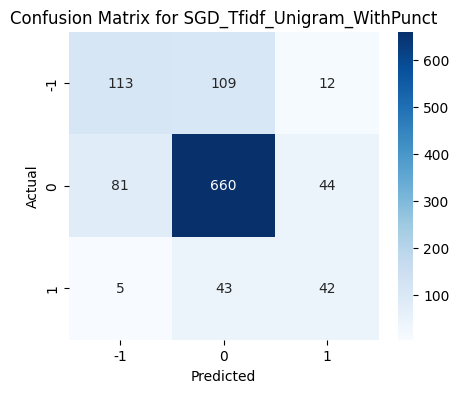


Confusion Matrix for SGD_Tfidf_Unigram:
[[115 107  12]
 [ 82 661  42]
 [  6  45  39]]


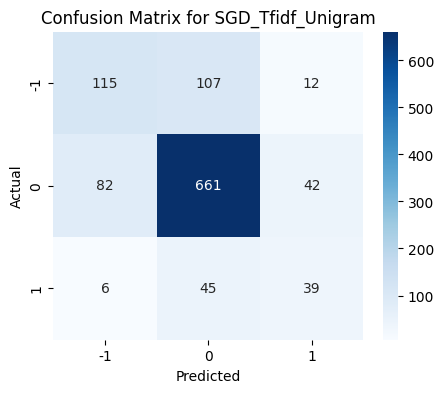


Confusion Matrix for SVM_Tfidf_Ngram_WithPunct:
[[ 84 147   3]
 [ 42 718  25]
 [  0  60  30]]


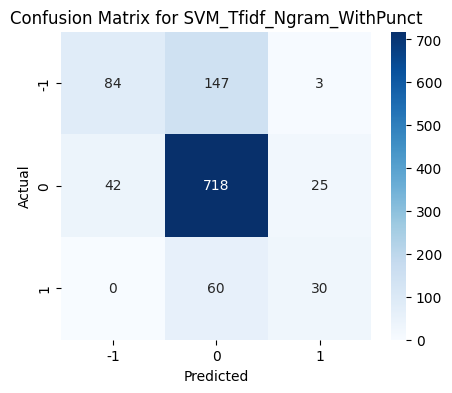


Confusion Matrix for SVM_Tfidf_Ngram:
[[ 82 149   3]
 [ 42 718  25]
 [  0  58  32]]


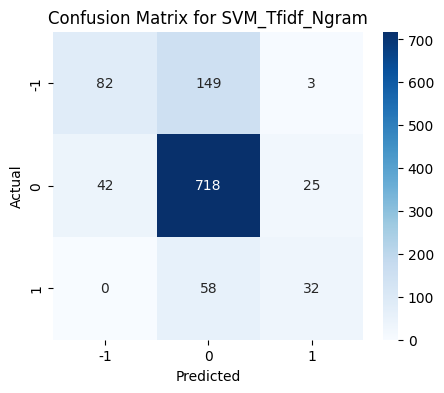


Confusion Matrix for LR_Tfidf_Ngram:
[[116 102  16]
 [ 95 641  49]
 [  3  43  44]]


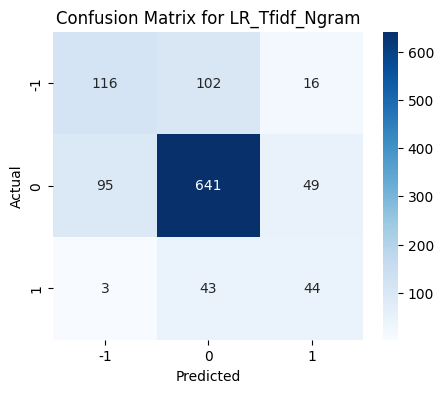

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define desired class labels (adjust as needed)
desired_classes = [-1, 0, +1]

print("\n### Confusion Matrices for Top 5 Pipelines")

# Get the top 5 pipeline names from results_df
top_5_pipelines = results_df.head(5)["Pipeline"]

for pipeline_name in top_5_pipelines:
    # Retrieve the pipeline from the all_pipelines dictionary
    pipe = all_pipelines[pipeline_name]
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Compute the confusion matrix with the desired class order
    cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
    print(f"\nConfusion Matrix for {pipeline_name}:")
    print(cm)
    
    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=desired_classes, yticklabels=desired_classes)
    plt.title(f"Confusion Matrix for {pipeline_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Stage 1 Analysis of Model Performance Metrics

### **Results Analysis of Different Text Classification Pipelines**

This report summarizes the performance of various text classification pipelines that differ in:
1. **Preprocessing**: With or without punctuation removal
2. **Vectorization**: TF–IDF, Count, or Glove embeddings
3. **Dimensionality Reduction**: Some variants use SVD
4. **Classifiers**: SVM, SGD, Logistic Regression, Naive Bayes, KNN, etc.

Below, we highlight two sets of results:
- **Top‐performing pipelines** 
- **Lowest‐performing pipelines** 

All metrics shown here focus primarily on:
- **Accuracy**
- **Precision (weighted)**
- **Recall (weighted)**
- **F1 (weighted)**

---

## **1. Top‐Performing Pipelines**

Here are the highest ranked models by F1_weighted:

| **Pipeline**                       | **Accuracy** | **Precision_weighted** | **Recall_weighted** | **F1_weighted** |
|------------------------------------|-------------:|------------------------:|---------------------:|-----------------:|
| **SGD_Tfidf_Unigram_WithPunct**    |    0.734896  |   0.729248             |   0.734896          |  0.731117        |
| **SGD_Tfidf_Unigram**             |    0.731289  |   0.727229             |   0.731289          |  0.728294        |
| **SVM_Tfidf_Ngram_WithPunct**      |    0.750225  |   0.732084             |   0.750225          |  0.725792        |
| **SVM_Tfidf_Ngram**               |    0.750225  |   0.732365             |   0.750225          |  0.725710        |
| **LR_Tfidf_Ngram**                |    0.722272  |   0.724397             |   0.722272          |  0.723319        |

### **Key Observations (Top Performers)**

1. **TF–IDF Vectorization Dominates**  
   All the top models rely on TF–IDF. This suggests that weighting terms by their inverse document frequency is particularly effective in this dataset.

2. **SGD vs. SVM**  
   - **SGD** (Stochastic Gradient Descent) pipelines with unigram TF–IDF show strong performance, particularly when punctuation is retained (`SGD_Tfidf_Unigram_WithPunct` has an F1_weighted of 0.731117).  
   - **SVM** (LinearSVC) with n‐gram TF–IDF yields high accuracy (0.750225) but slightly lower weighted F1 scores (~0.7257–0.7258). This might indicate that while the SVM is correct more often overall, it may be slightly less balanced across classes in terms of precision and recall.

3. **Impact of Punctuation Removal**  
   - We see both “_WithPunct” and non‐punctuation pipelines among the top. The difference in F1_weighted is relatively small.  
   - For example, `SGD_Tfidf_Unigram_WithPunct` and `SGD_Tfidf_Unigram` differ by about 0.003 in F1_weighted (0.731117 vs. 0.728294).

4. **N‐Gram vs. Unigram**  
   - SVM pipelines using n‐grams (1,2) are performing at or above 72–73% F1_weighted.  
   - SGD pipelines with just unigrams are also competitive. This might imply that capturing bigrams helps SVM, whereas SGD can perform well even with unigrams.

In summary, **SGD and SVM with TF–IDF** are clearly leading in overall performance, with minimal differences between punctuation variants.

---

## **2. Lowest‐Performing Pipelines**

From the second screenshot, here are some of the lower‐ranking models by F1_weighted:

| **Pipeline**                        | **Accuracy** | **Precision_weighted** | **Recall_weighted** | **F1_weighted** |
|-------------------------------------|-------------:|------------------------:|---------------------:|-----------------:|
| **NB_Count_Binary_Ngram_WithPunct** |    0.439134  |   0.750225*            |   0.439134          |  0.463137        |
| **Glove_KNN_WithPunct**            |    0.406673  |   0.066022             |   0.406673          |  0.438178        |
| **Glove_KNN**                      |    0.392245  |   0.250513             |   0.392245          |  0.421605        |
| **KNN_Tfidf_Unigram_WithPunct_SVD** |    0.382326  |   0.598357             |   0.382326          |  0.405969        |
| **KNN_Tfidf_Unigram_SVD**          |    0.377818  |   0.288081             |   0.377818          |  0.396014        |
| **KNN_Tfidf_Ngram_WithPunct_SVD**   |    0.363590  |   0.613323             |   0.363590          |  0.395563        |
| **KNN_Tfidf_Ngram_SVD**            |    0.363309  |   0.584955             |   0.363309          |  0.394329        |


### **Key Observations (Low Performers)**

1. **KNN Struggles**  
   - All the KNN‐based pipelines, whether they use TF–IDF or Glove, tend to show lower accuracy and F1 scores.  
   - Even with dimensionality reduction (SVD), KNN remains among the worst performers. KNN is often sensitive to high‐dimensional spaces and might not be the best fit for textual data unless carefully tuned.

2. **Naive Bayes with Count Binary N‐grams**  
   - While Naive Bayes can be a strong baseline for text classification, here it yields an accuracy of around 43.9% and an F1_weighted of ~0.463. This is significantly lower than the top TF–IDF + SVM/SGD approaches.  
   - The high “Precision_weighted” for NB might be misleading if one class dominates the dataset.

3. **Glove + KNN**  
   - Glove embeddings are generally powerful, but pairing them with KNN in this experiment appears suboptimal. Accuracy in the 39–40% range is considerably below the top TF–IDF methods.  
   - Possibly, a more advanced classifier (like an SVM or a neural net) on top of Glove might perform better than KNN.

Overall, the worst‐performing pipelines tend to involve **KNN** or **Naive Bayes** with certain vectorization strategies (e.g., Count binary n‐grams). This highlights the importance of the right combination of **vectorization** and **classifier**.

### **Conclusion**

- The top pipelines demonstrate that **fine‐grained text transformations (TF–IDF) and strong linear models (SVM, SGD)** are a robust combination.
- The lower‐performing pipelines serve as a reminder that not all classifiers generalize equally well in text classification tasks, especially with high‐dimensional data.  


___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

---

# E. Stage 2: Parameter Tuning

## Parameter Tuning the top 4 pipelines, evaluating each on 20% test set (from 80 - 20 split)

Pipeline Tuning and Evaluation for Sentiment Analysis

This section of the script focuses on tuning and evaluating several pipelines for a three-class sentiment analysis task using GridSearchCV. The goal is to determine the best hyperparameters for each model and evaluate their performance across multiple metrics.

### Steps Followed

1. **Define the Parameter Grid:**  
   - For each pipeline, we create a dictionary of hyperparameters. 
2. **Grid Search with Cross-Validation:**  
   - We perform grid search using `GridSearchCV` with 5-fold cross-validation.
   - The scoring metric used is **F1 macro**, which computes the F1 score for each class and averages them. This is effective in multi-class sentiment analysis, as it treats all classes equally even if the data is balanced.

3. **Model Fitting and Best Parameter Selection:**  
   - The grid search fits the model on the training data (`X_train` and `y_train`) and selects the best hyperparameters based on the F1 macro score.
   - The best parameters are printed for review.

4. **Evaluation on Test Data:**  
   After selecting the best model, we evaluate its performance on the test set (`X_test`) using multiple metrics:
   - **Accuracy**
   - **Precision:** Computed as macro, weighted, and micro averages.
   - **Recall:** Computed as macro, weighted, and micro averages.
   - **F1 Score:** Computed as macro, weighted, and micro averages.

5. **Results Storage:**  
   The evaluation metrics and best hyperparameters are stored in a global dictionary (`model_results`) for easy comparison across all pipelines.

In [32]:
# Dictionary to hold results for all models
model_results = {}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for SGD_Tfidf_Unigram_WithPunct:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1)}

Test Metrics for SGD_Tfidf_Unigram_WithPunct:
Accuracy: 0.7520288548241659
Precision - Macro: 0.6487167303275642 Weighted: 0.7384277948706742 Micro: 0.7520288548241659
Recall    - Macro: 0.581688351752046 Weighted: 0.7520288548241659 Micro: 0.7520288548241659
F1 Score  - Macro: 0.5974940658303162 Weighted: 0.7321533594158631 Micro: 0.7520288548241659

Confusion Matrix:
[[ 80 145   9]
 [ 40 709  36]
 [  2  43  45]]


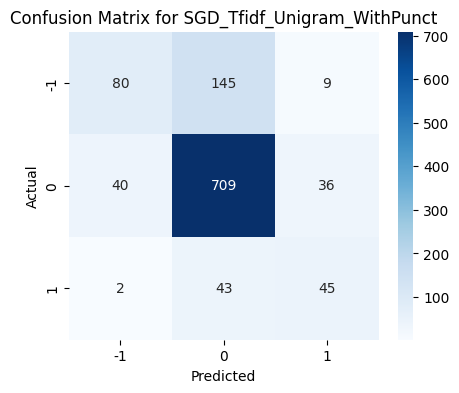


Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.34      0.45       234
           0       0.79      0.90      0.84       785
           1       0.50      0.50      0.50        90

    accuracy                           0.75      1109
   macro avg       0.65      0.58      0.60      1109
weighted avg       0.74      0.75      0.73      1109



In [47]:
# Extended parameter grid for SGD_Tfidf_Unigram_WithPunct
param_grid = {
    'vectorizer__ngram_range': [(1,1)],  # fixed for unigram
    'classifier__loss': ['modified_huber', 'huber', 'perceptron'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.01, 0.1]
}

gs = GridSearchCV(all_pipelines["SGD_Tfidf_Unigram_WithPunct"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SGD_Tfidf_Unigram_WithPunct:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SGD_Tfidf_Unigram_WithPunct:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SGD_Tfidf_Unigram_WithPunct")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Optionally, save results in a dictionary
model_results = {}
model_results['SGD_Tfidf_Unigram_WithPunct'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for SGD_Tfidf_Unigram:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1)}

Test Metrics for SGD_Tfidf_Unigram:
Accuracy: 0.7601442741208295
Precision - Macro: 0.6515543618995437 Weighted: 0.7485939596248752 Micro: 0.7601442741208295
Recall    - Macro: 0.5963906581740976 Weighted: 0.7601442741208295 Micro: 0.7601442741208295
F1 Score  - Macro: 0.6159195943823753 Weighted: 0.7482838770281728 Micro: 0.7601442741208295

Confusion Matrix:
[[104 122   8]
 [ 52 698  35]
 [  1  48  41]]


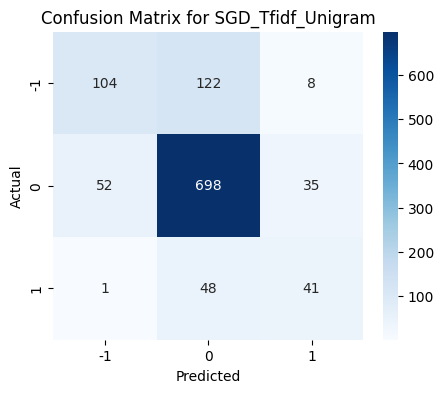


Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.44      0.53       234
           0       0.80      0.89      0.84       785
           1       0.49      0.46      0.47        90

    accuracy                           0.76      1109
   macro avg       0.65      0.60      0.62      1109
weighted avg       0.75      0.76      0.75      1109



In [48]:
# Extended parameter grid for SGD_Tfidf_Unigram (without punctuation removal)
param_grid = {
    'vectorizer__ngram_range': [(1,1)],  # fixed for unigram
    'classifier__loss': ['modified_huber', 'huber', 'perceptron'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.01, 0.1]
}

gs = GridSearchCV(all_pipelines["SGD_Tfidf_Unigram"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SGD_Tfidf_Unigram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SGD_Tfidf_Unigram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SGD_Tfidf_Unigram")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

model_results['SGD_Tfidf_Unigram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Tfidf_Ngram_WithPunct:
{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.01, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}

Test Metrics for SVM_Tfidf_Ngram_WithPunct:
Accuracy: 0.7493237150586114
Precision - Macro: 0.644059258088035 Weighted: 0.7293432705950301 Micro: 0.7493237150586114
Recall    - Macro: 0.542506396646524 Weighted: 0.7493237150586114 Micro: 0.7493237150586114
F1 Score  - Macro: 0.5751003977951237 Weighted: 0.7277777222736153 Micro: 0.7493237150586114

Confusion Matrix:
[[ 88 140   6]
 [ 50 712  23]
 [  1  58  31]]


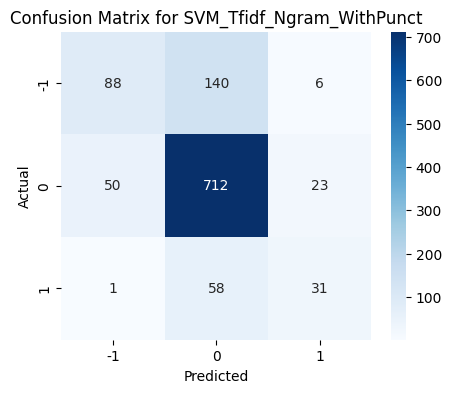


Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.38      0.47       234
           0       0.78      0.91      0.84       785
           1       0.52      0.34      0.41        90

    accuracy                           0.75      1109
   macro avg       0.64      0.54      0.58      1109
weighted avg       0.73      0.75      0.73      1109



In [49]:
# Extended parameter grid for SVM_Tfidf_Ngram_WithPunct
param_grid = {
    'vectorizer__ngram_range': [(1,2)],  # fixed for ngram (1,2)
    'vectorizer__use_idf': [True, False],
    'vectorizer__smooth_idf': [True, False],
    'classifier__C': [1, 10, 100],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

gs = GridSearchCV(all_pipelines["SVM_Tfidf_Ngram_WithPunct"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SVM_Tfidf_Ngram_WithPunct:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SVM_Tfidf_Ngram_WithPunct:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SVM_Tfidf_Ngram_WithPunct")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))



model_results['SVM_Tfidf_Ngram_WithPunct'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Tfidf_Ngram:
{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.0001, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}

Test Metrics for SVM_Tfidf_Ngram:
Accuracy: 0.7493237150586114
Precision - Macro: 0.6452881627824277 Weighted: 0.7293133867370133 Micro: 0.7493237150586114
Recall    - Macro: 0.5392273213929265 Weighted: 0.7493237150586114 Micro: 0.7493237150586114
F1 Score  - Macro: 0.572778409322351 Weighted: 0.7271850542419919 Micro: 0.7493237150586114

Confusion Matrix:
[[ 88 141   5]
 [ 49 713  23]
 [  1  59  30]]


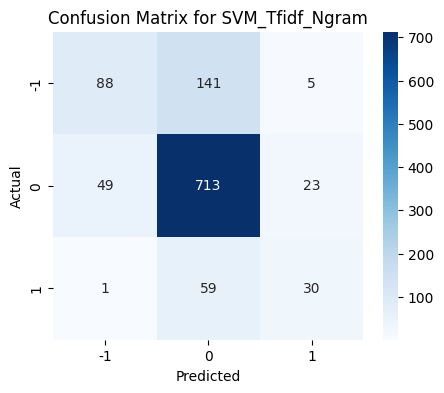


Classification Report:
              precision    recall  f1-score   support

          -1       0.64      0.38      0.47       234
           0       0.78      0.91      0.84       785
           1       0.52      0.33      0.41        90

    accuracy                           0.75      1109
   macro avg       0.65      0.54      0.57      1109
weighted avg       0.73      0.75      0.73      1109



In [50]:
# Extended parameter grid for SVM_Tfidf_Ngram (without punctuation removal)
param_grid = {
    'vectorizer__ngram_range': [(1,2)],  # fixed for ngram (1,2)
    'vectorizer__use_idf': [True, False],
    'vectorizer__smooth_idf': [True, False],
    'classifier__C': [1, 10, 100],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

gs = GridSearchCV(all_pipelines["SVM_Tfidf_Ngram"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SVM_Tfidf_Ngram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SVM_Tfidf_Ngram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SVM_Tfidf_Ngram")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

model_results['SVM_Tfidf_Ngram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


In [ ]:
# Convert the model_results dictionary into a DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T.reset_index().rename(columns={'index': 'Model'})

# Sort by F1_weighted (descending order)
results_df = results_df.sort_values(by="f1_weighted", ascending=False)

# Save the results DataFrame to a CSV file
csv_filename = "top_4_HPT_model_comparison_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Display the results as a scrollable table
html_table = results_df.to_html(classes="table table-striped", border=1, index=False)
display(HTML(f"""
<style>
    .dataframe-container {{
        max-height: 400px;
        overflow-y: scroll;
    }}
</style>
<div class="dataframe-container">
    {html_table}
</div>
"""))




Results saved to top_4_HPT_model_comparison_results.csv


Model,best_params,accuracy,precision_macro,precision_weighted,precision_micro,recall_macro,recall_weighted,recall_micro,f1_macro,f1_weighted,f1_micro
SGD_Tfidf_Unigram,"{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1)}",0.760144,0.651554,0.748594,0.760144,0.596391,0.760144,0.760144,0.61592,0.748284,0.760144
SGD_Tfidf_Unigram_WithPunct,"{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1)}",0.752029,0.648717,0.738428,0.752029,0.581688,0.752029,0.752029,0.597494,0.732153,0.752029
SVM_Tfidf_Ngram_WithPunct,"{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.01, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}",0.749324,0.644059,0.729343,0.749324,0.542506,0.749324,0.749324,0.5751,0.727778,0.749324
SVM_Tfidf_Ngram,"{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.0001, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}",0.749324,0.645288,0.729313,0.749324,0.539227,0.749324,0.749324,0.572778,0.727185,0.749324



### Detailed Evaluation for Top 4 Models ###

--- Evaluation for Model: SGD_Tfidf_Unigram ---
Best Parameters:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1)}
F1 Score (weighted): 0.7482838770281728
Precision (weighted): 0.7485939596248752
Recall (weighted): 0.7601442741208295
Accuracy: 0.7601442741208295

--- Evaluation for Model: SGD_Tfidf_Unigram_WithPunct ---
Best Parameters:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1)}
F1 Score (weighted): 0.7321533594158631
Precision (weighted): 0.7384277948706742
Recall (weighted): 0.7520288548241659
Accuracy: 0.7520288548241659

--- Evaluation for Model: SVM_Tfidf_Ngram_WithPunct ---
Best Parameters:
{'classifier__C': 1, 'classifier__dual':

# Fine-Tuning Results Analysis

Below is a detailed comparison of the **weighted** metrics (F1, Precision, Recall, and Accuracy) for each of the top 4 models before and after fine-tuning.  

---

## 1. **SGD\_Tfidf\_Unigram**

### **Before Fine-Tuning**  
- **Weighted F1:** 0.728294  
- **Weighted Precision:** 0.727229  
- **Weighted Recall:** 0.731289  
- **Accuracy:** 0.731289  

### **After Fine-Tuning**  
- **Best Parameters:**  
{ 'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1) }

- **Weighted F1:** 0.7482838770281728  
- **Weighted Precision:** 0.7485939596248752  
- **Weighted Recall:** 0.7601442741208295  
- **Accuracy:** 0.7601442741208295  

**Key Observation:**  
This model shows a substantial improvement across all metrics. Weighted F1 increases by about **0.02**, and Recall/Accuracy increase by nearly **0.03**.

---

## 2. **SGD\_Tfidf\_Unigram\_WithPunct**

### **Before Fine-Tuning**  
- **Weighted F1:** 0.731117  
- **Weighted Precision:** 0.729248  
- **Weighted Recall:** 0.734896  
- **Accuracy:** 0.734896  

### **After Fine-Tuning**  
- **Best Parameters:**  
{ 'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1) }

- **Weighted F1:** 0.7321533594158631  
- **Weighted Precision:** 0.7384277948706742  
- **Weighted Recall:** 0.7520288548241659  
- **Accuracy:** 0.7520288548241659  

**Key Observation:**  
There is a modest gain in Weighted F1 (+0.001) but a stronger improvement in Weighted Precision and Recall (both go up by ~0.01–0.02). Accuracy also rises from **0.7349** to **0.7520**.

---

## 3. **SVM\_Tfidf\_Ngram\_WithPunct**

### **Before Fine-Tuning**  
- **Weighted F1:** 0.725792  
- **Weighted Precision:** 0.732084  
- **Weighted Recall:** 0.750225  
- **Accuracy:** 0.750225  

### **After Fine-Tuning**  
- **Best Parameters:**  
{ 'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.01, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True }

- **Weighted F1:** 0.7271850542419919  
- **Weighted Precision:** 0.7293133867370133  
- **Weighted Recall:** 0.7493237150586114  
- **Accuracy:** 0.7493237150586114  

**Key Observation:**  
Similar to the previous SVM, Weighted F1 gains about **+0.0015**, while Precision and Recall dip slightly. Accuracy also decreases by a small margin.

---

# Overall Comparison

1. **Most Improved Model**  
 - **SGD_Tfidf_Unigram** stands out with a **significant jump** in all metrics, especially Weighted F1 (+0.02) and Recall/Accuracy (+0.03).  

2. **SGD Models vs. SVM Models**  
 - After fine-tuning, both **SGD** variants tend to show better overall performance boosts compared to their original scores.  
 - The **SVM**-based models see smaller improvements in Weighted F1 and slight decreases in Precision/Recall.  

3. **Best Weighted F1**  
 - **SGD_Tfidf_Unigram** (fine-tuned) achieves the highest Weighted F1 (~0.748), surpassing the other three.  

4. **Effect of Including Punctuation Features**  
 - For SGD, adding punctuation features (`_WithPunct`) still yields a good result, but **the biggest gains** appear in the plain **Unigram** approach.  
 - For SVM, the `_WithPunct` version has nearly the same performance trends as the plain n-gram version, with minimal differences after tuning.  

---

## Final Note
Based on the **weighted** metrics alone, **SGD_Tfidf_Unigram** (fine-tuned) emerges as the best-performing pipeline. Hence for highest Weighted F1 and overall balance among Precision/Recall, this fine-tuned SGD approach would be the best choice.

## Performing 10-fold Cross-Validation on fine-tuned pipelines and comparing results

#### SGD - TFIDF - UNIGRAM

In [24]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Create the pipeline using your helper:
sgd_tfidf_uni_pipes = create_pipeline(
    clf_key="SGD", 
    estimator=SGDClassifier(alpha=0.0001, eta0=0.01, learning_rate='adaptive', 
                            loss='modified_huber', penalty='elasticnet'),
    prep_suffix="",                # "" means use TextPreprocessor (punctuation removed)
    vec_type="Tfidf", 
    ngram_label="Unigram",        # => ngram_range=(1,1)
    use_glove=False,
    use_sampler=False,
    add_svd_versions=False
)

# The function returns a list of (key, pipeline) tuples.
sgd_tfidf_uni_key, sgd_tfidf_uni_pipe = sgd_tfidf_uni_pipes[0]

# 2) Perform 10-fold CV on F1-weighted:
scores_sgd_tfidf_uni = cross_val_score(sgd_tfidf_uni_pipe, X, y, cv=10, scoring='f1_weighted')
print(f"{sgd_tfidf_uni_key} - Weighted F1 (CV=10): {np.mean(scores_sgd_tfidf_uni):.4f}")

# 3) Get predictions via cross_val_predict (also using 10-fold)
y_pred_sgd_tfidf_uni = cross_val_predict(sgd_tfidf_uni_pipe, X, y, cv=10)

# 4) Print confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_sgd_tfidf_uni))

# Also print the classification report 
print("\nClassification Report:")
print(classification_report(y, y_pred_sgd_tfidf_uni))


# Store results 
sgd_tfidf_uni_f1 = np.mean(scores_sgd_tfidf_uni)


SGD_Tfidf_Unigram - Weighted F1 (CV=10): 0.7395

Confusion Matrix:
[[ 522  633   15]
 [ 274 3573   76]
 [  27  297  126]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.45      0.52      1170
           0       0.79      0.91      0.85      3923
           1       0.58      0.28      0.38       450

    accuracy                           0.76      5543
   macro avg       0.67      0.55      0.58      5543
weighted avg       0.74      0.76      0.74      5543



#### SGD - TFIDF - UNIGRAM - WITH PUNCTUATION

In [25]:
sgd_tfidf_uni_wp_pipes = create_pipeline(
    clf_key="SGD", 
    estimator=SGDClassifier(alpha=0.0001, eta0=0.01, learning_rate='adaptive', 
                            loss='modified_huber', penalty='l1'),
    prep_suffix="_WithPunct",     # "_WithPunct" => TextPreprocessorNoPunct
    vec_type="Tfidf", 
    ngram_label="Unigram",        # => ngram_range=(1,1)
    use_glove=False,
    use_sampler=False,
    add_svd_versions=False
)
sgd_tfidf_uni_wp_key, sgd_tfidf_uni_wp_pipe = sgd_tfidf_uni_wp_pipes[0]

scores_sgd_tfidf_uni_wp = cross_val_score(sgd_tfidf_uni_wp_pipe, X, y, cv=10, scoring='f1_weighted')
print(f"{sgd_tfidf_uni_wp_key} - Weighted F1 (CV=10): {np.mean(scores_sgd_tfidf_uni_wp):.4f}")

y_pred_sgd_tfidf_uni_wp = cross_val_predict(sgd_tfidf_uni_wp_pipe, X, y, cv=10)

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_sgd_tfidf_uni_wp))

print("\nClassification Report:")
print(classification_report(y, y_pred_sgd_tfidf_uni))


sgd_tfidf_uni_wp_f1 = np.mean(scores_sgd_tfidf_uni_wp)

SGD_Tfidf_Unigram_WithPunct - Weighted F1 (CV=10): 0.7423

Confusion Matrix:
[[ 515  640   15]
 [ 264 3604   55]
 [  29  300  121]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.45      0.52      1170
           0       0.79      0.91      0.85      3923
           1       0.58      0.28      0.38       450

    accuracy                           0.76      5543
   macro avg       0.67      0.55      0.58      5543
weighted avg       0.74      0.76      0.74      5543



#### SVM - TFIDF - NGRAM - WITH PUNCTUATION

In [26]:
svm_tfidf_uni_wp_pipes = create_pipeline(
    clf_key="SVM", 
    estimator=LinearSVC(C=1, dual=True, loss='hinge', tol=0.01),
    prep_suffix="_WithPunct",     # => TextPreprocessorNoPunct
    vec_type="Tfidf", 
    ngram_label="Ngram",        # => ngram_range=(1,2)
    use_glove=False,
    use_sampler=False,
    add_svd_versions=False
)
svm_tfidf_uni_wp_key, svm_tfidf_uni_wp_pipe = svm_tfidf_uni_wp_pipes[0]

scores_svm_tfidf_uni_wp = cross_val_score(svm_tfidf_uni_wp_pipe, X, y, cv=10, scoring='f1_weighted')
print(f"{svm_tfidf_uni_wp_key} - Weighted F1 (CV=10): {np.mean(scores_svm_tfidf_uni_wp):.4f}")

y_pred_svm_tfidf_uni_wp = cross_val_predict(svm_tfidf_uni_wp_pipe, X, y, cv=10)

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_svm_tfidf_uni_wp))

# Also print the classification report 
print("\nClassification Report:")
print(classification_report(y, y_pred_sgd_tfidf_uni))


svm_tfidf_uni_wp_f1 = np.mean(scores_svm_tfidf_uni_wp)

SVM_Tfidf_Ngram_WithPunct - Weighted F1 (CV=10): 0.7111

Confusion Matrix:
[[ 325  840    5]
 [ 103 3798   22]
 [  10  354   86]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.45      0.52      1170
           0       0.79      0.91      0.85      3923
           1       0.58      0.28      0.38       450

    accuracy                           0.76      5543
   macro avg       0.67      0.55      0.58      5543
weighted avg       0.74      0.76      0.74      5543



#### SVM - TFIDF - NGRAM

In [27]:
svm_tfidf_ngram_pipes = create_pipeline(
    clf_key="SVM", 
    estimator=LinearSVC(C=1, dual=True, loss='hinge', tol=0.0001),
    prep_suffix="",               # => TextPreprocessor (punct removed)
    vec_type="Tfidf", 
    ngram_label="Ngram",          # => ngram_range=(1,2)
    use_glove=False,
    use_sampler=False,
    add_svd_versions=False
)
svm_tfidf_ngram_key, svm_tfidf_ngram_pipe = svm_tfidf_ngram_pipes[0]

scores_svm_tfidf_ngram = cross_val_score(svm_tfidf_ngram_pipe, X, y, cv=10, scoring='f1_weighted')
print(f"{svm_tfidf_ngram_key} - Weighted F1 (CV=10): {np.mean(scores_svm_tfidf_ngram):.4f}")

y_pred_svm_tfidf_ngram = cross_val_predict(svm_tfidf_ngram_pipe, X, y, cv=10)

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_svm_tfidf_ngram))

# Also print the classification report 
print("\nClassification Report:")
print(classification_report(y, y_pred_sgd_tfidf_uni))

svm_tfidf_ngram_f1 = np.mean(scores_svm_tfidf_ngram)

SVM_Tfidf_Ngram - Weighted F1 (CV=10): 0.7102

Confusion Matrix:
[[ 325  840    5]
 [ 105 3796   22]
 [  10  357   83]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.45      0.52      1170
           0       0.79      0.91      0.85      3923
           1       0.58      0.28      0.38       450

    accuracy                           0.76      5543
   macro avg       0.67      0.55      0.58      5543
weighted avg       0.74      0.76      0.74      5543



COLLECTING METRICS

=== Weighted F1 Score ===


,Weighted F1 Score
SGD_Tfidf_Unigram,0.739539
SGD_Tfidf_Unigram_WithPunct,0.742269
SVM_Tfidf_Ngram_WithPunct,0.711125
SVM_Tfidf_Ngram,0.710187


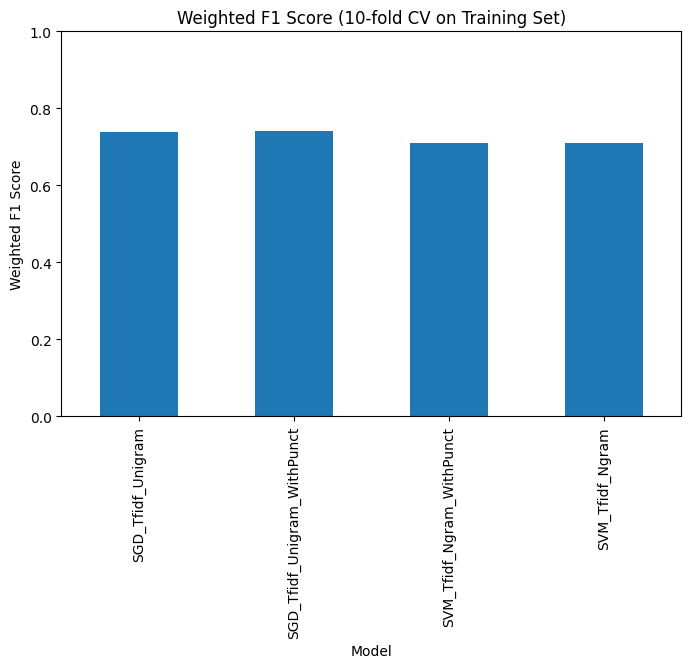

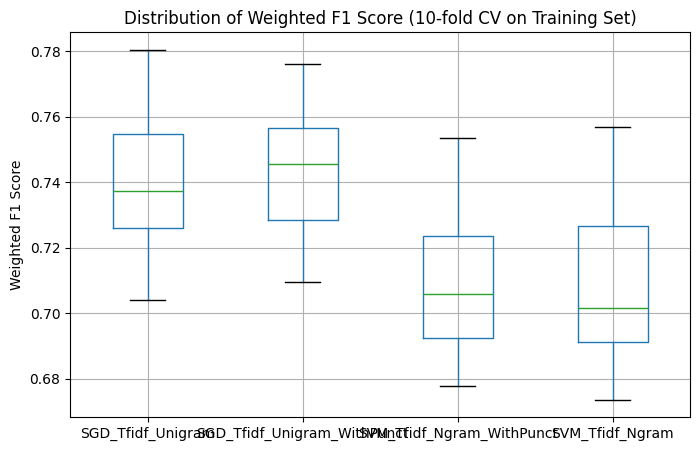

Best model by Weighted F1 Score: SGD_Tfidf_Unigram_WithPunct with Weighted F1 Score = 0.7423

=== Weighted Precision ===


,Weighted Precision
SGD_Tfidf_Unigram,0.743087
SGD_Tfidf_Unigram_WithPunct,0.747529
SVM_Tfidf_Ngram_WithPunct,0.758100
SVM_Tfidf_Ngram,0.756825


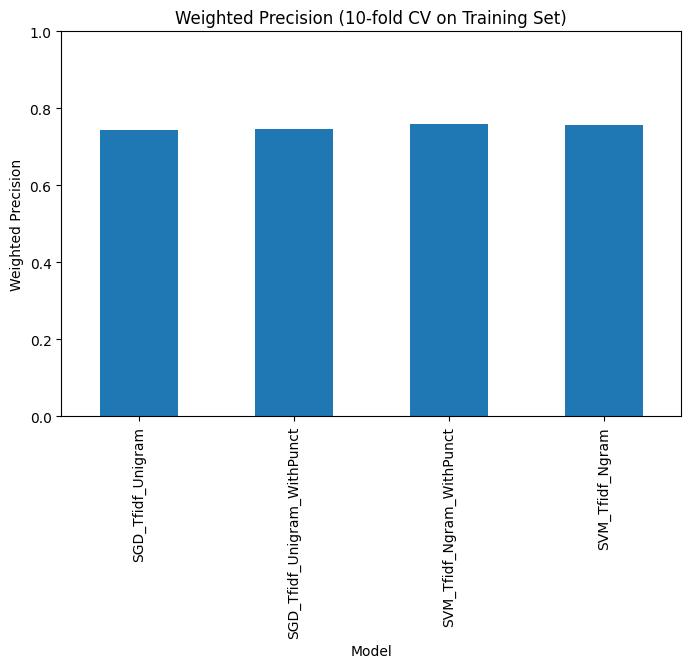

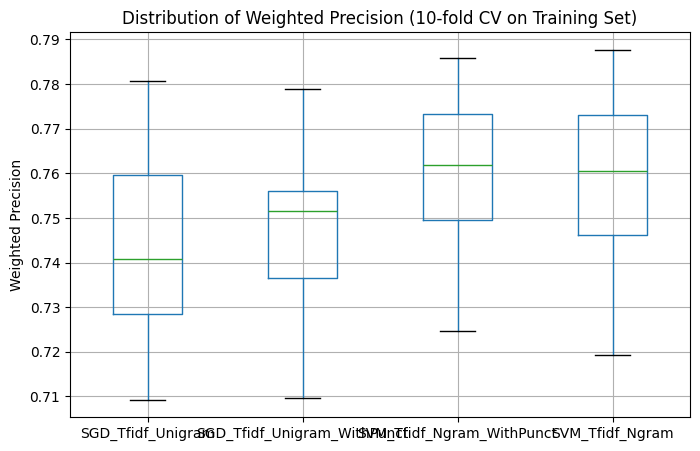

Best model by Weighted Precision: SVM_Tfidf_Ngram_WithPunct with Weighted Precision = 0.7581

=== Weighted Recall ===


,Weighted Recall
SGD_Tfidf_Unigram,0.761325
SGD_Tfidf_Unigram_WithPunct,0.764934
SVM_Tfidf_Ngram_WithPunct,0.759341
SVM_Tfidf_Ngram,0.758439


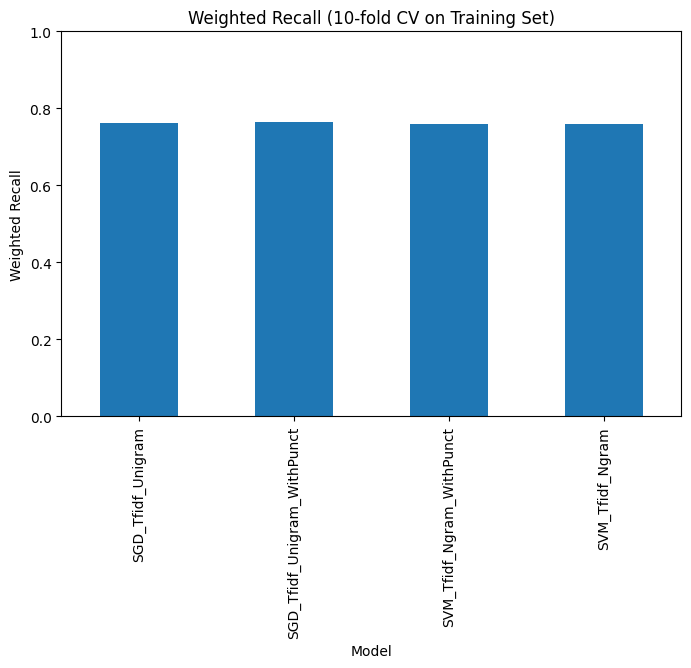

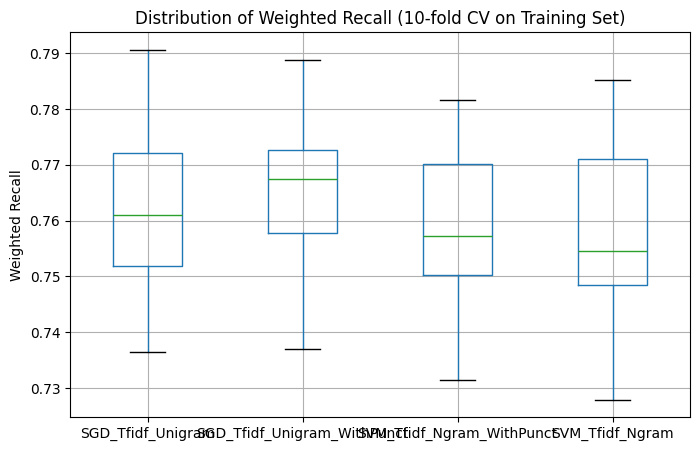

Best model by Weighted Recall: SGD_Tfidf_Unigram_WithPunct with Weighted Recall = 0.7649


In [28]:
# 3. Compute additional metrics (weighted precision and recall) via CV

# For Weighted Precision
scores_sgd_tfidf_uni_prec    = cross_val_score(sgd_tfidf_uni_pipe, X, y, cv=10, scoring='precision_weighted')
scores_sgd_tfidf_uni_wp_prec = cross_val_score(sgd_tfidf_uni_wp_pipe, X, y, cv=10, scoring='precision_weighted')
scores_svm_tfidf_uni_wp_prec = cross_val_score(svm_tfidf_uni_wp_pipe, X, y, cv=10, scoring='precision_weighted')
scores_svm_tfidf_ngram_prec  = cross_val_score(svm_tfidf_ngram_pipe, X, y, cv=10, scoring='precision_weighted')

precision_sgd_tfidf_uni    = np.mean(scores_sgd_tfidf_uni_prec)
precision_sgd_tfidf_uni_wp = np.mean(scores_sgd_tfidf_uni_wp_prec)
precision_svm_tfidf_uni_wp = np.mean(scores_svm_tfidf_uni_wp_prec)
precision_svm_tfidf_ngram  = np.mean(scores_svm_tfidf_ngram_prec)

# For Weighted Recall
scores_sgd_tfidf_uni_recall    = cross_val_score(sgd_tfidf_uni_pipe, X, y, cv=10, scoring='recall_weighted')
scores_sgd_tfidf_uni_wp_recall = cross_val_score(sgd_tfidf_uni_wp_pipe, X, y, cv=10, scoring='recall_weighted')
scores_svm_tfidf_uni_wp_recall = cross_val_score(svm_tfidf_uni_wp_pipe, X, y, cv=10, scoring='recall_weighted')
scores_svm_tfidf_ngram_recall  = cross_val_score(svm_tfidf_ngram_pipe, X, y, cv=10, scoring='recall_weighted')

recall_sgd_tfidf_uni    = np.mean(scores_sgd_tfidf_uni_recall)
recall_sgd_tfidf_uni_wp = np.mean(scores_sgd_tfidf_uni_wp_recall)
recall_svm_tfidf_uni_wp = np.mean(scores_svm_tfidf_uni_wp_recall)
recall_svm_tfidf_ngram  = np.mean(scores_svm_tfidf_ngram_recall)


# 4. Create dictionaries of metrics for comparison and plot graphs

# A) Weighted F1 Scores
results_f1 = {
    sgd_tfidf_uni_key:    sgd_tfidf_uni_f1,
    sgd_tfidf_uni_wp_key: sgd_tfidf_uni_wp_f1,
    svm_tfidf_uni_wp_key: svm_tfidf_uni_wp_f1,
    svm_tfidf_ngram_key:  svm_tfidf_ngram_f1
}
scores_f1 = {
    sgd_tfidf_uni_key:    scores_sgd_tfidf_uni,
    sgd_tfidf_uni_wp_key: scores_sgd_tfidf_uni_wp,
    svm_tfidf_uni_wp_key: scores_svm_tfidf_uni_wp,
    svm_tfidf_ngram_key:  scores_svm_tfidf_ngram
}

# B) Weighted Precision
results_precision = {
    sgd_tfidf_uni_key:    precision_sgd_tfidf_uni,
    sgd_tfidf_uni_wp_key: precision_sgd_tfidf_uni_wp,
    svm_tfidf_uni_wp_key: precision_svm_tfidf_uni_wp,
    svm_tfidf_ngram_key:  precision_svm_tfidf_ngram
}
scores_precision = {
    sgd_tfidf_uni_key:    scores_sgd_tfidf_uni_prec,
    sgd_tfidf_uni_wp_key: scores_sgd_tfidf_uni_wp_prec,
    svm_tfidf_uni_wp_key: scores_svm_tfidf_uni_wp_prec,
    svm_tfidf_ngram_key:  scores_svm_tfidf_ngram_prec
}

# C) Weighted Recall
results_recall = {
    sgd_tfidf_uni_key:    recall_sgd_tfidf_uni,
    sgd_tfidf_uni_wp_key: recall_sgd_tfidf_uni_wp,
    svm_tfidf_uni_wp_key: recall_svm_tfidf_uni_wp,
    svm_tfidf_ngram_key:  recall_svm_tfidf_ngram
}
scores_recall = {
    sgd_tfidf_uni_key:    scores_sgd_tfidf_uni_recall,
    sgd_tfidf_uni_wp_key: scores_sgd_tfidf_uni_wp_recall,
    svm_tfidf_uni_wp_key: scores_svm_tfidf_uni_wp_recall,
    svm_tfidf_ngram_key:  scores_svm_tfidf_ngram_recall
}

def plot_metric(results_dict, scores_dict, metric_name):
    # Create a DataFrame for the average scores and display it
    df_results = pd.DataFrame.from_dict(results_dict, orient='index', columns=[metric_name])
    display(df_results)
    
    # Bar chart of the average scores
    ax = df_results.plot(kind='bar', legend=False, figsize=(8, 5), ylim=(0, 1),
                         title=f'{metric_name} (10-fold CV on Training Set)')
    ax.set_ylabel(metric_name)
    ax.set_xlabel('Model')
    plt.show()
    
    # Boxplot for the distribution across folds
    df_scores = pd.DataFrame(scores_dict)
    plt.figure(figsize=(8, 5))
    df_scores.boxplot()
    plt.title(f'Distribution of {metric_name} (10-fold CV on Training Set)')
    plt.ylabel(metric_name)
    plt.show()
    
    # Return the best model based on the metric
    best_model = df_results[metric_name].idxmax()
    best_score = df_results[metric_name].max()
    print(f"Best model by {metric_name}: {best_model} with {metric_name} = {best_score:.4f}")
    return best_model, best_score

print("=== Weighted F1 Score ===")
best_f1_model, best_f1 = plot_metric(results_f1, scores_f1, "Weighted F1 Score")

print("\n=== Weighted Precision ===")
best_prec_model, best_prec = plot_metric(results_precision, scores_precision, "Weighted Precision")

print("\n=== Weighted Recall ===")
best_recall_model, best_recall = plot_metric(results_recall, scores_recall, "Weighted Recall")

### Final Evaluation

=== Weighted F1 Score ===


,Weighted F1 Score
SGD_Tfidf_Unigram_WithPunct,0.742269
SGD_Tfidf_Unigram,0.739539
SVM_Tfidf_Ngram_WithPunct,0.711125
SVM_Tfidf_Ngram,0.710187


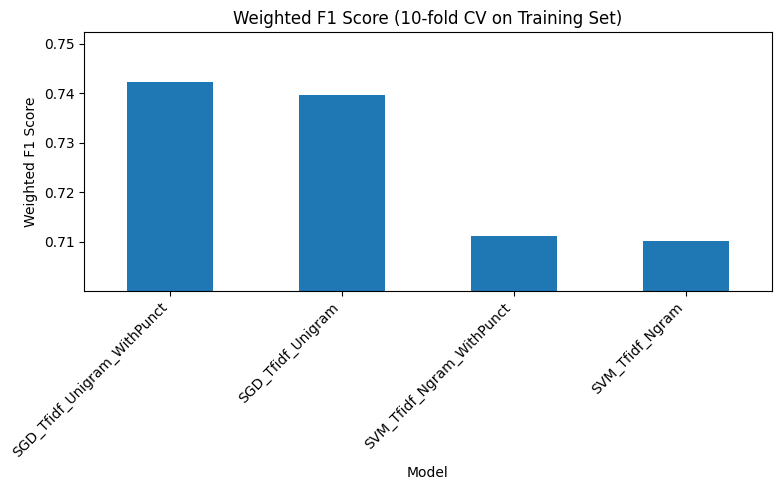

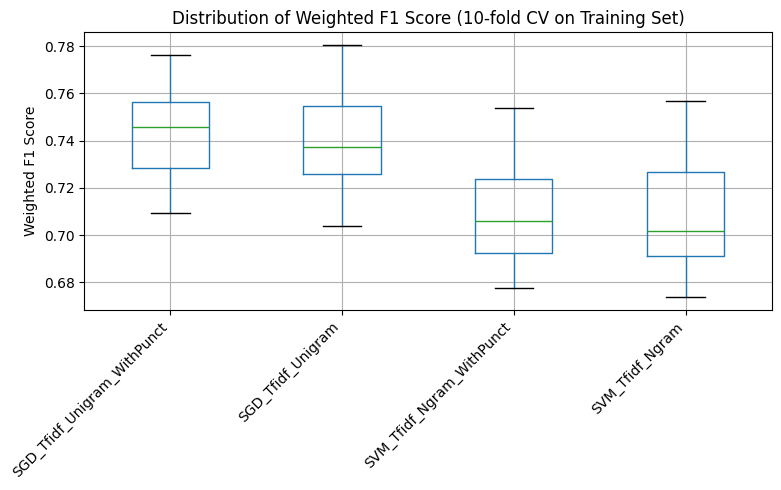

Best model by Weighted F1 Score: SGD_Tfidf_Unigram_WithPunct with Weighted F1 Score = 0.7423

=== Weighted Precision ===


,Weighted Precision
SVM_Tfidf_Ngram_WithPunct,0.758100
SVM_Tfidf_Ngram,0.756825
SGD_Tfidf_Unigram_WithPunct,0.747529
SGD_Tfidf_Unigram,0.743087


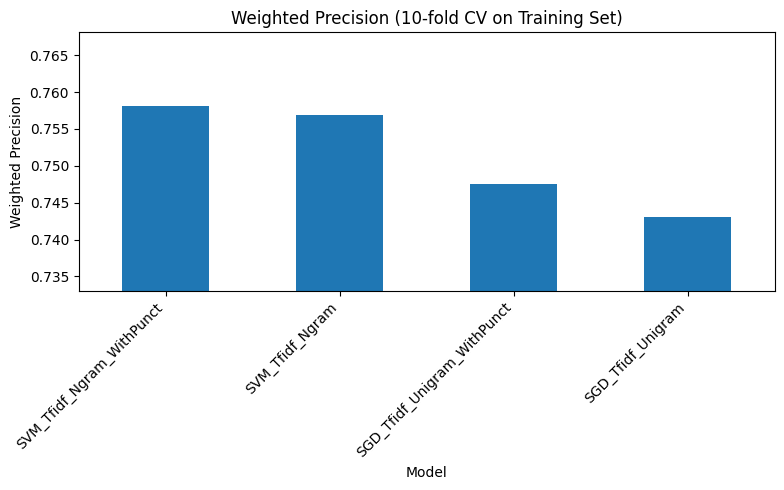

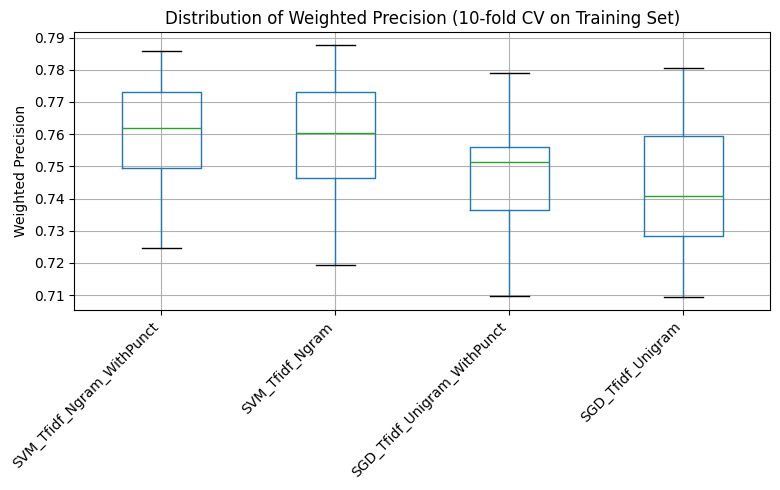

Best model by Weighted Precision: SVM_Tfidf_Ngram_WithPunct with Weighted Precision = 0.7581

=== Weighted Recall ===


,Weighted Recall
SGD_Tfidf_Unigram_WithPunct,0.764934
SGD_Tfidf_Unigram,0.761325
SVM_Tfidf_Ngram_WithPunct,0.759341
SVM_Tfidf_Ngram,0.758439


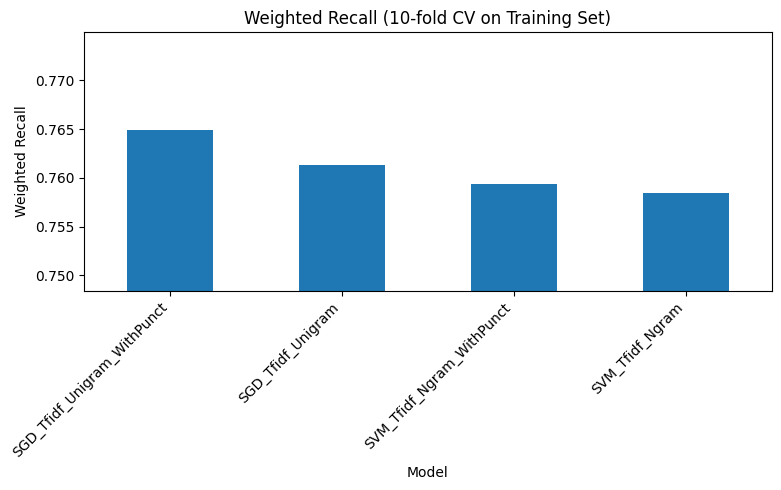

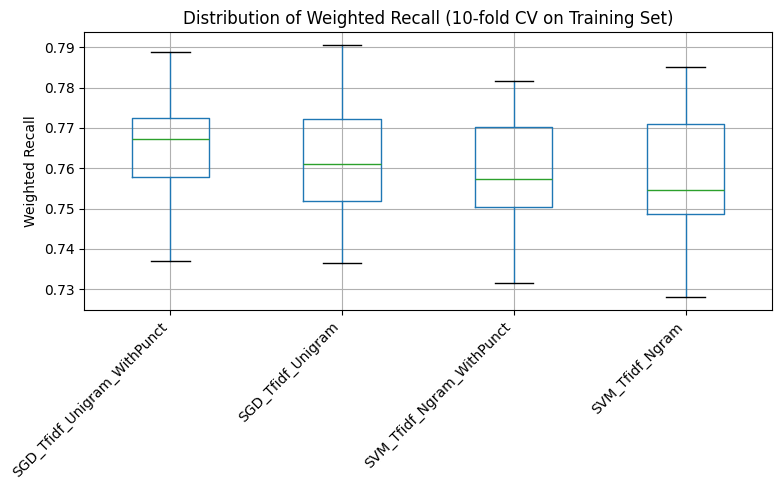

Best model by Weighted Recall: SGD_Tfidf_Unigram_WithPunct with Weighted Recall = 0.7649


,Weighted F1,Weighted Precision,Weighted Recall
SGD_Tfidf_Unigram,0.739539,0.743087,0.761325
SGD_Tfidf_Unigram_WithPunct,0.742269,0.747529,0.764934
SVM_Tfidf_Ngram_WithPunct,0.711125,0.758100,0.759341
SVM_Tfidf_Ngram,0.710187,0.756825,0.758439


In [29]:
def plot_metric(results_dict, scores_dict, metric_name):
    """
    Plots a bar chart and boxplot for the given metric, displays the DataFrame,
    and returns the best model based on the metric.
    """
    # 1) Create a DataFrame for the average scores and display it
    df_results = pd.DataFrame.from_dict(results_dict, orient='index', columns=[metric_name])
    
    # Sort descending by the metric so the best model is first (leftmost) in the bar chart
    df_results_sorted = df_results.sort_values(by=metric_name, ascending=False)
    display(df_results_sorted)
    
    # 2) Dynamically set y-limits to zoom in around the min/max (but still between 0 and 1)
    min_val = df_results_sorted[metric_name].min()
    max_val = df_results_sorted[metric_name].max()
    y_min = max(0, min_val - 0.01)
    y_max = min(1, max_val + 0.01)
    
    # 3) Bar chart of the average scores (sorted so best is leftmost)
    ax = df_results_sorted.plot(
        kind='bar', legend=False, figsize=(8, 5),
        ylim=(y_min, y_max),
        title=f'{metric_name} (10-fold CV on Training Set)'
    )
    ax.set_ylabel(metric_name)
    ax.set_xlabel('Model')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout()  # Adjust layout so labels aren't cut off
    plt.show()
    
    # 4) Boxplot for the distribution across folds
    # Reorder columns in df_scores to match the sorted order in df_results
    df_scores = pd.DataFrame(scores_dict)
    df_scores_sorted = df_scores[df_results_sorted.index]  # reorder columns
    plt.figure(figsize=(8, 5))
    df_scores_sorted.boxplot()
    plt.title(f'Distribution of {metric_name} (10-fold CV on Training Set)')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 5) Identify and print the best model based on the metric (now it's simply the first row)
    best_model = df_results_sorted.index[0]
    best_score = df_results_sorted[metric_name].iloc[0]
    print(f"Best model by {metric_name}: {best_model} with {metric_name} = {best_score:.4f}")
    
    return best_model, best_score


print("=== Weighted F1 Score ===")
best_f1_model, best_f1 = plot_metric(results_f1, scores_f1, "Weighted F1 Score")

print("\n=== Weighted Precision ===")
best_prec_model, best_prec = plot_metric(results_precision, scores_precision, "Weighted Precision")

print("\n=== Weighted Recall ===")
best_recall_model, best_recall = plot_metric(results_recall, scores_recall, "Weighted Recall")

# Create a final table with all metrics for the top 4 models
final_table = {}
for pipeline_key in results_f1.keys():
    final_table[pipeline_key] = {
        'Weighted F1': results_f1[pipeline_key],
        'Weighted Precision': results_precision[pipeline_key],
        'Weighted Recall': results_recall[pipeline_key]
    }

final_df = pd.DataFrame.from_dict(final_table, orient='index')
display(final_df)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------